Found 70 images belonging to 14 classes.
Found 140 images belonging to 14 classes.
3/3 [==============================] - 3s 746ms/step - loss: 0.4482 - accuracy: 0.8286
Found 140 images belonging to 14 classes.
3/3 [==============================] - 3s 739ms/step - loss: 0.5840 - accuracy: 0.8143
Found 140 images belonging to 14 classes.
3/3 [==============================] - 4s 956ms/step - loss: 0.6864 - accuracy: 0.7857
Found 140 images belonging to 14 classes.
3/3 [==============================] - 3s 750ms/step - loss: 0.6536 - accuracy: 0.7857
Found 140 images belonging to 14 classes.
3/3 [==============================] - 3s 735ms/step - loss: 0.6566 - accuracy: 0.7714


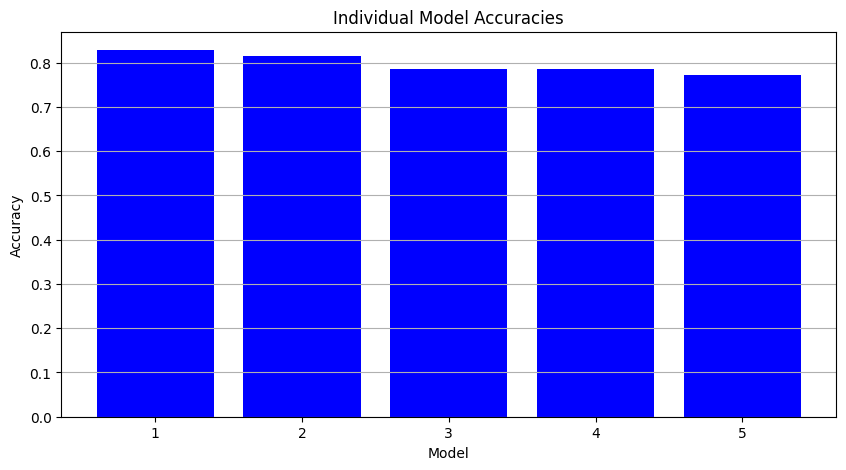

3/3 [==============================] - 6s 743ms/step


3/3 [==============================] - 4s 917ms/step - loss: 0.6566 - accuracy: 0.7714
Ensemble Test Loss: 0.6566
Ensemble Test Accuracy: 0.7714


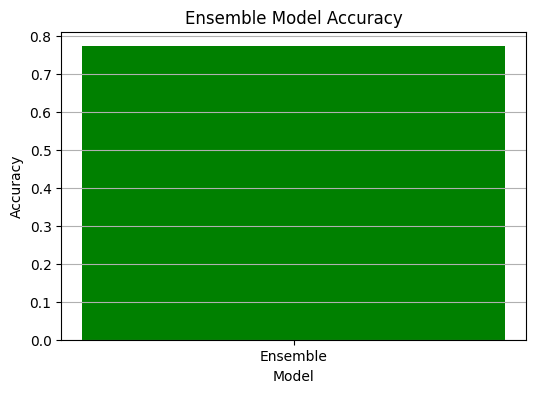

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define parameters
image_size = (150, 150)
batch_size = 32
num_epochs = 30
train_data_dir = '/content/drive/MyDrive/plantdisease/train_leaf'
test_data_dir = '/content/drive/MyDrive/plantdisease/test_leaf'
num_models = 5  # Number of models to train

# Enhanced Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3
)

# Rescale the pixel values for the test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test data with a maximum of 30 photos per class
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Train multiple models using bagging
models = []
model_accuracies = []

for i in range(num_models):
    # Load training data with a maximum of 30 photos per class
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=i,  # Use different seeds for randomization
        interpolation='nearest'
    )

    # Use InceptionV3 as a base model with transfer learning
    base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

    # Add custom head for classification with additional Dense layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Additional Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model except the added layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with the enhanced configuration
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=num_epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size,
        verbose=0
    )

    models.append(model)

    # Evaluate each model and store their accuracies
    _, accuracy = model.evaluate(test_generator)
    model_accuracies.append(accuracy)

# Plot individual model accuracies
plt.figure(figsize=(10, 5))
plt.bar(range(1, num_models + 1), model_accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Individual Model Accuracies')
plt.xticks(range(1, num_models + 1))
plt.grid(axis='y')
plt.show()

# Ensemble predictions
ensemble_predictions = np.zeros((len(test_generator.classes), len(test_generator.class_indices)))

# Weighted average based on model accuracies
for model, accuracy in zip(models, model_accuracies):
    predictions = model.predict(test_generator)
    ensemble_predictions += accuracy * predictions

# Normalize predictions
ensemble_predictions /= sum(model_accuracies)

# Evaluate the ensemble model on the test data
ensemble_loss, ensemble_accuracy = model.evaluate(test_generator)
print(f'Ensemble Test Loss: {ensemble_loss:.4f}')
print(f'Ensemble Test Accuracy: {ensemble_accuracy:.4f}')

# Plot ensemble model accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Ensemble'], [ensemble_accuracy], color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Ensemble Model Accuracy')
plt.grid(axis='y')
plt.show()


bagging


Found 140 images belonging to 14 classes.
Found 70 images belonging to 14 classes.


Epoch 1/30
4/4 [==============================] - 17s 3s/step - loss: 3.8177 - accuracy: 0.1019 - val_loss: 2.3641 - val_accuracy: 0.2500
Epoch 2/30
4/4 [==============================] - 13s 4s/step - loss: 3.6303 - accuracy: 0.1389 - val_loss: 2.0337 - val_accuracy: 0.2812
Epoch 3/30
4/4 [==============================] - 11s 3s/step - loss: 3.1337 - accuracy: 0.2315 - val_loss: 1.7835 - val_accuracy: 0.5000
Epoch 4/30
4/4 [==============================] - 11s 3s/step - loss: 2.8800 - accuracy: 0.1759 - val_loss: 1.6494 - val_accuracy: 0.4062
Epoch 5/30
4/4 [==============================] - 13s 4s/step - loss: 2.4193 - accuracy: 0.2685 - val_loss: 1.5994 - val_accuracy: 0.3906
Epoch 6/30
4/4 [==============================] - 11s 3s/step - loss: 2.4992 - accuracy: 0.3241 - val_loss: 1.5015 - val_accuracy: 0.5156
Epoch 7/30
4/4 [==============================] - 11s 2s/step - loss: 2.1573 - accuracy: 0.3359 - val_loss: 1.2684 - val_accuracy: 0.5938
Epoch 8/30
4/4 [==================

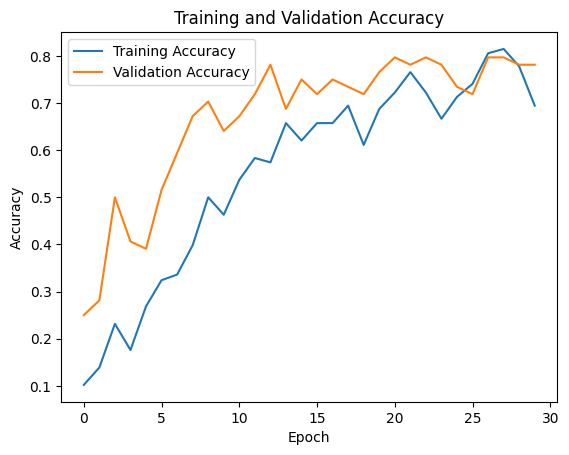

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Define parameters
image_size = (150, 150)
batch_size = 32
num_epochs = 30
train_data_dir = '/content/drive/MyDrive/plantdisease/train_leaf'
test_data_dir = '/content/drive/MyDrive/plantdisease/test_leaf'

# Enhanced Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3
)

# Rescale the pixel values for the test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data with a maximum of 30 photos per class
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Load test data with a maximum of 30 photos per class
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Base model - InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom head for classification with additional Dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train base learner
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Extract features from penultimate layer of base model
features_train = base_model.predict(train_generator)
features_test = base_model.predict(test_generator)

# Reshape features_train and features_test
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)

# Initialize AdaBoost classifier
adaboost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),  # Use decision trees as weak learners
    n_estimators=num_epochs  # Train for the same number of epochs as the original model
)

# Train AdaBoost classifier
adaboost.fit(features_train_flat, train_generator.classes)

# Evaluate AdaBoost classifier
ensemble_accuracy = adaboost.score(features_test_flat, test_generator.classes)
print(f'Ensemble Test Accuracy: {ensemble_accuracy:.4f}')

# Visualize accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


boosting

Found 140 images belonging to 14 classes.
Found 70 images belonging to 14 classes.


Epoch 1/30
4/4 [==============================] - 19s 3s/step - loss: 3.4471 - accuracy: 0.0833 - val_loss: 2.4081 - val_accuracy: 0.2188
Epoch 2/30
4/4 [==============================] - 8s 2s/step - loss: 3.2185 - accuracy: 0.2037 - val_loss: 1.8416 - val_accuracy: 0.4375
Epoch 3/30
4/4 [==============================] - 9s 2s/step - loss: 2.6409 - accuracy: 0.2407 - val_loss: 1.5695 - val_accuracy: 0.4531
Epoch 4/30
4/4 [==============================] - 11s 3s/step - loss: 2.6795 - accuracy: 0.2969 - val_loss: 1.5212 - val_accuracy: 0.4375
Epoch 5/30
4/4 [==============================] - 11s 3s/step - loss: 2.3032 - accuracy: 0.3333 - val_loss: 1.2419 - val_accuracy: 0.6719
Epoch 6/30
4/4 [==============================] - 9s 2s/step - loss: 2.1360 - accuracy: 0.3889 - val_loss: 1.4380 - val_accuracy: 0.5156
Epoch 7/30
4/4 [==============================] - 10s 3s/step - loss: 2.1549 - accuracy: 0.3056 - val_loss: 1.2785 - val_accuracy: 0.5469
Epoch 8/30
4/4 [=====================

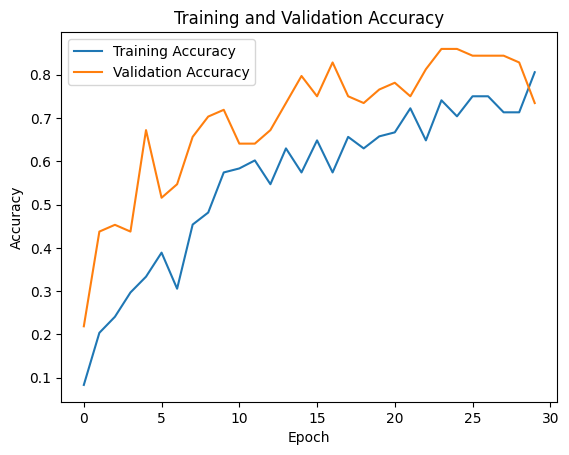

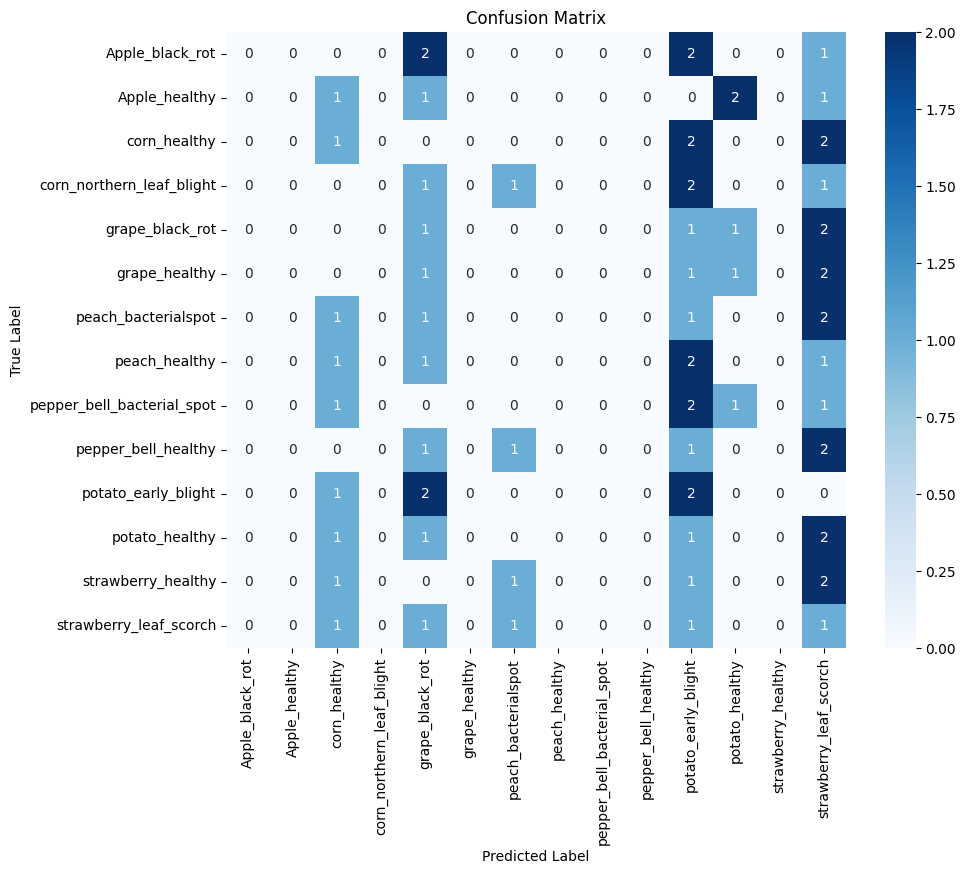

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameters
image_size = (150, 150)
batch_size = 32
num_epochs = 30
train_data_dir = '/content/drive/MyDrive/plantdisease/train_leaf'
test_data_dir = '/content/drive/MyDrive/plantdisease/test_leaf'

# Enhanced Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3
)

# Rescale the pixel values for the test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data with a maximum of 30 photos per class
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Load test data with a maximum of 30 photos per class
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Base model - InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom head for classification with additional Dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train base learner
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Extract features from penultimate layer of base model
features_train = base_model.predict(train_generator)
features_test = base_model.predict(test_generator)

# Reshape features_train and features_test
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)

# Split data for stacking
X_train, X_val, y_train, y_val = train_test_split(features_train_flat, train_generator.classes, test_size=0.2, random_state=42)

# Train base models for stacking
base_model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
base_model_1.fit(X_train, y_train)
base_model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
base_model_2.fit(X_train, y_train)

# Make predictions on validation data for stacking
preds_val_1 = base_model_1.predict(X_val)
preds_val_2 = base_model_2.predict(X_val)

# Stack predictions for meta-model input
stacked_X_val = np.column_stack((preds_val_1, preds_val_2))

# Train meta-model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(stacked_X_val, y_val)

# Make predictions on test data for stacking
preds_test_1 = base_model_1.predict(features_test_flat)
preds_test_2 = base_model_2.predict(features_test_flat)

# Stack predictions for meta-model input
stacked_X_test = np.column_stack((preds_test_1, preds_test_2))

# Make predictions using meta-model
final_predictions = meta_model.predict(stacked_X_test)

# Evaluate accuracy
test_accuracy = accuracy_score(test_generator.classes, final_predictions)
print(f'Test Accuracy after stacking: {test_accuracy:.4f}')

# Visualize accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Confusion matrix for meta-model's predictions on test data
cm = confusion_matrix(test_generator.classes, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
